# COMP24112 - Exercise 3: _Face Recognition_ (25 Marks)

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [1]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt


Now you can load the data:

In [2]:
data, labels = load_data()

### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

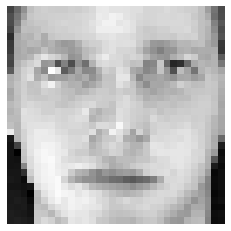

In [3]:
# Display a single example.
show_single_face(data[0, :])

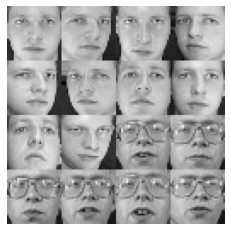

In [4]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [5]:
# normalization
data = data / 255

# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares (13 Marks in Total)
### 3.1 Implementation (5 Marks, Easy)
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [6]:
def l2_rls_train(data, labels, input_lambda
  # Add any other arguments here
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
#     following the note, we should add ones before the first column of X, instead of at the end
    one = np.ones((X.shape[0], 1))
    X_tilde = np.append(one, X, axis=1)
     
    # Compute the coefficient vector.
#     indentity matrix
    I = np.eye(X_tilde.shape[0])
    
#     When  λ= 0 , use a pseudo-inverse to implement the solution.
    if input_lambda == 0:
#         When input lambda is 0, it is better to use pinv than inv as referenced,because it can be used when the matrix is singular
#         if the label is 1D:
        if len(y.shape) == 1:
#         it is to add one more dimension so the matrix multiplication can be done
            w = np.linalg.pinv(X_tilde)@y[:,None]
        else:
            w = np.linalg.pinv(X_tilde)@y
    else: 
#         w = X.T(X*X.T)^-1*y
        if len(y.shape) == 1:
            w = (X_tilde.T @ np.linalg.inv(X_tilde@X_tilde.T + input_lambda * I)) @ y[:, None]       
        else:
            w = (X_tilde.T @ np.linalg.inv(X_tilde@X_tilde.T + input_lambda * I)) @y

    # Return model parameters.
    return w

Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [7]:
def l2_rls_predict(w, data):
    """
    A summary of your function goes here.

    data: type and description of "data"
    w: type and description of "w"

    Returns: type and description of the returned variable(s).
    """
    
   # Compute the prediction.
    
# as the notes stated, the prediction function is y=W.T * x
# x is the result after adding ones before the first column of data
    one = np.ones((data.shape[0], 1))
    X_tilde = np.append(one, data, axis=1)

    predicted_y = X_tilde @ w
    
    return predicted_y



#### Report

Explain briefly the knowledge supported your implementation and your design step by step.

### 3.2 Experiments (2 experiments to be implemented) 

Use your implemented functions to perform the following experiments. Experiment 1 is compulsory. Between Experiment 2 and Experiment 3, choose one as you like.

#### Experiment 1: Binary Classification (4 Marks, Normal)

Start with a binary classification to classify face images for subjects “1” and “30”.

Train three classifiers:
<br>Classifier 1. Set $y=-1$ for samples from “1” and $y=+1$ for samples from “30” for training a linear model, and use the threshold $T= 0$ to obtain the class prediction.
<br>Classifier 2. Set $y=0$ for samples from “1” and $y=1$ for samples from “30” for training a linear model, and use the threshold $T= 0.5$ to obtain the class prediction.
<br>Classifier 3. Set $y=1$ for samples from “1” and $y=30$ for samples from “30” for training a linear model, and use the threshold $T= 15.5$ to obtain the class prediction.

Randomly select 3 images per subject for training, and use the remaining images for testing. Train your classifier 1 and test it with a fixed regularisation parameter $\lambda$=0. Repeat this process 50 times and record the training and test errors.

In [8]:
def b_class(sample_1, sample_30):
    training_error = np.zeros([50])
    testing_error = np.zeros([50])   
    
#     threshold value
    T = (sample_1+sample_30)/2
    
#     repeat the process 50 times
    for i in range(50):
    
        all_labels = np.concatenate((labels[0:10], labels[290: 300]))
        all_data = np.concatenate((data[0:10, ], data[290: 300, :]))
#         selecting 3 images per class    
        training_ind, testing_ind = partition_data(all_labels, num_per_class = 3)
    
        training_data = all_data[training_ind, :]
#         the training data is total length 6 because we are getting 3 images per subject for training - sample_1 and 3
        training_label = np.zeros(6)
        training_label[0:3] = sample_1        
        training_label[3:6] = sample_30
        testing_data = all_data[testing_ind, :]
        
#         lambda for it is 0
        w = l2_rls_train(training_data, training_label, 0)
        
        predict_training = l2_rls_predict(w,training_data)        
        predict_testing = l2_rls_predict(w,testing_data)

        training_error[i] = ((predict_training[0:3, :] >= T).sum() + (predict_training[3:6, :]<T).sum())/6;
        testing_error[i] = ((predict_testing[0:7, :] >= T).sum() + (predict_testing[7:14, :]<T).sum())/14;

    return training_error,testing_error



In [9]:
classifier_1_training, classifier_1_testing = b_class(-1,1)
# print(classifier_1_training)
# print(classifier_1_testing)

Repeat the same experiment for classifier 2.

In [10]:
classifier_2_training, classifier_2_testing = b_class(0,1)
# print(classifier_2_training)
# print(classifier_2_testing)

Repeat the same experiment for classifier 3.

In [11]:
classifier_3_training, classifier_3_testing = b_class(1,30)
# print(classifier_3_training)
# print(classifier_3_testing)

Print out the mean and the std values of the test errors of the three classifiers.

In [12]:
print("Classificer 1: ")
print("Mean:                  Training error -> " + str(np.mean(classifier_1_training)) + " | Testing error -> " + str(np.mean(classifier_1_testing)))
print("standard deviation:    Training error -> " + str(np.std(classifier_1_training)) + " | Testing error -> " + str(np.std(classifier_1_testing)) )

print("\nClassificer 2: ")
print("Mean:                  Training error -> " + str(np.mean(classifier_2_training)) + " | Testing error -> " + str(np.mean(classifier_2_testing)))
print("standard deviation:    Training error -> " + str(np.std(classifier_2_training)) + " | Testing error -> " + str(np.std(classifier_2_testing)) )

print("\nClassificer 3: ")
print("Mean:                  Training error -> " + str(np.mean(classifier_3_training)) + " | Testing error -> " + str(np.mean(classifier_3_testing)))
print("standard deviation:    Training error -> " + str(np.std(classifier_3_training)) + " | Testing error -> " + str(np.std(classifier_3_testing)) )

Classificer 1: 
Mean:                  Training error -> 0.0 | Testing error -> 0.07142857142857142
standard deviation:    Training error -> 0.0 | Testing error -> 0.08329931278350429

Classificer 2: 
Mean:                  Training error -> 0.0 | Testing error -> 0.07571428571428572
standard deviation:    Training error -> 0.0 | Testing error -> 0.08620099909454622

Classificer 3: 
Mean:                  Training error -> 0.0 | Testing error -> 0.06
standard deviation:    Training error -> 0.0 | Testing error -> 0.0774069553379661


In [13]:
# Addition classifier
classifier_4_training, classifier_4_testing = b_class(1,10)
classifier_5_training, classifier_5_testing = b_class(1,20)
classifier_6_training, classifier_6_testing = b_class(1,40)

print("\nClassificer 4: ")
print("Mean:                  Training error -> " + str(np.mean(classifier_4_training)) + " | Testing error -> " + str(np.mean(classifier_4_testing)))
print("standard deviation:    Training error -> " + str(np.std(classifier_4_training)) + " | Testing error -> " + str(np.std(classifier_4_testing)) )

print("\nClassificer 5: ")
print("Mean:                  Training error -> " + str(np.mean(classifier_5_training)) + " | Testing error -> " + str(np.mean(classifier_5_testing)))
print("standard deviation:    Training error -> " + str(np.std(classifier_5_training)) + " | Testing error -> " + str(np.std(classifier_5_testing)) )

print("\nClassificer 6: ")
print("Mean:                  Training error -> " + str(np.mean(classifier_6_training)) + " | Testing error -> " + str(np.mean(classifier_6_testing)))
print("standard deviation:    Training error -> " + str(np.std(classifier_6_training)) + " | Testing error -> " + str(np.std(classifier_6_testing)) )



Classificer 4: 
Mean:                  Training error -> 0.0 | Testing error -> 0.08142857142857142
standard deviation:    Training error -> 0.0 | Testing error -> 0.09368858532611196

Classificer 5: 
Mean:                  Training error -> 0.0 | Testing error -> 0.06857142857142857
standard deviation:    Training error -> 0.0 | Testing error -> 0.0832502987676198

Classificer 6: 
Mean:                  Training error -> 0.0 | Testing error -> 0.10714285714285714
standard deviation:    Training error -> 0.0 | Testing error -> 0.1222660197758835


#### Report

Explain the classification steps. Does changing the class labels impact the model performance? Explain why it does/doesn't impact.  What training accuracies do you obtain with your linear classifier? Analyse the reason.

#### Experiment 2: Multi-class Classification (4 Marks, Normal)

Now, proceed to the multi-class classification task to classify face images for all the 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

#### Report

Explain the classification steps. How do you pick the most difficult and easiest subjects to classify,  analyse the results.

#### Experiment 3: Face Completion (4 Marks, Normal)

The task is to predic the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [14]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

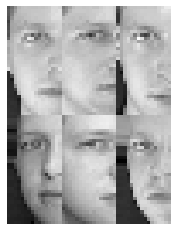

In [15]:
show_split_faces(left[:6, :], num_per_row=3)

Build a face completion model using your functions implemented earlier. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [16]:
def face_com(training_data_left, training_data_right, testing_data_left, testing_data_right):
    training_error = np.zeros([50])
    testing_error = np.zeros([50])  
    
#         lambda for it is 0
    w = l2_rls_train(training_data_left, training_data_right, 0)
    predict_face = l2_rls_predict(w,testing_data_left)  
    MAE = np.zeros(200)
    
    
#     it is 200 because we split half to training and half to testing
    for i in range(200):
#         512 stands for the pixel of the right face
        m = np.zeros(512)
        for j in range(512):
#              Mean absolute error: 1/n * abs(y - y1)
            m[j] = np.abs(testing_data_right[i, j] - predict_face[i,j])/testing_data_right[i,j]
        MAE[i] = m.sum()
    
    error_rate = MAE.sum()/ (200*512)
            
    return error_rate, predict_face



Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

The error rate is:  21.7 %


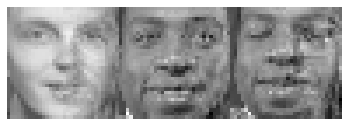

In [17]:

# splitting the data into half
training_ind, testing_ind = partition_data(labels, num_per_class= 5)
left, right = split_left_right(data)
# left_l, right_l = split_left_right(labels)
subjects = np.random.choice(200, size=3, replace=False)

training_data_left = left[training_ind, :]
training_data_right = right[training_ind, :]
testing_data_left = left[testing_ind, :]
testing_data_right = right[testing_ind, :]

left_face = testing_data_left[subjects, :]
error, right_face = face_com(training_data_left, training_data_right, testing_data_left, testing_data_right)
    
right_face = right_face[subjects, :]


face = join_left_right(left_face, right_face)

show_faces(face, num_per_row = 3)

print("The error rate is: ", round(error*100, 1), "%")

#### Report

Analyse results of face completion model, how well your model performed, how it can be improved? 


## 4. Gradient descent for training linear least squares model (5 Marks in Total, Normal)

Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [18]:

def lls_gd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    one = np.ones((X.shape[0], 1))
    X_tilde = np.append(one, X, axis=1)
    
    # Weight initialization
    w = np.zeros(X_tilde.shape[1])
    
    cost_all = []
    w_all = []
    
    # GD update of weights
    for i in range(N):
        
        predicted_y = X_tilde @ w
        gd = X_tilde.T @X_tilde @w - X_tilde.T @ y
        cost = np.sum(np.square(predicted_y - y))/ 2

        # Weight update
        w = w - learning_rate * gd
        # save w and cost of each iteration in w_all and cost_all 
        w_all.append(w)
        cost_all.append(cost)
    
    # Return model parameters.
    return cost_all, w_all


Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it compiles. 

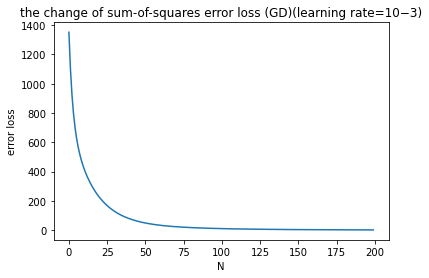

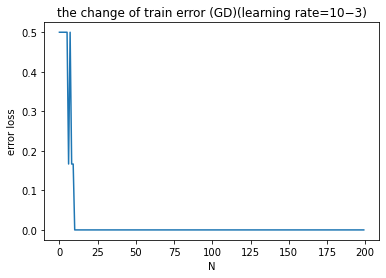

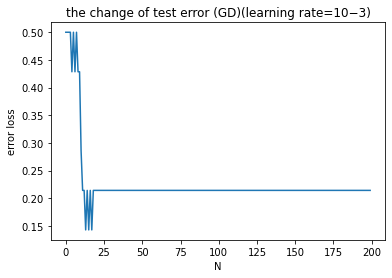

In [19]:

all_labels = np.concatenate((labels[0:10], labels[290: 300]))
all_data = np.concatenate((data[0:10, ], data[290: 300, :]))
# selecting 3 images per class    
training_ind, testing_ind = partition_data(all_labels, num_per_class = 3)

training_data = all_data[training_ind, :]
# the training data is total length 6 because we are getting 3 images per subject for training - sample_1 and 3
training_label = np.zeros(6)
training_label[0:3] = 1        
training_label[3:6] = 30
# testing_data.shape[0] =  14- every sample has 10 images, after taking 3 from each sample, there 7 each for the testing data.
testing_data = all_data[testing_ind, :]
testing_label = np.zeros(14)
testing_label[0:7] = 1
testing_label[7:14] = 30
 

gd_cost_all, gd_w_all = lls_gd_train(training_data, training_label, 10**(-3), 200)

gd_training_error = np.zeros(200)
gd_testing_error = np.zeros(200)
T = (1+30)/2

for i in range(200):
    
    gd_predict_training = l2_rls_predict(gd_w_all[i], training_data)
    gd_predict_testing = l2_rls_predict(gd_w_all[i], testing_data)
#     using the threshold value (mean of two subjects) to classify the subject
    gd_training_error[i] = ((gd_predict_training[0:3] >= T).sum() + (gd_predict_training[3:6]<T).sum())/6;
    gd_testing_error[i] = ((gd_predict_testing[0:7] >= T).sum() + (gd_predict_testing[7:14]<T).sum())/14;


plt.title("the change of sum-of-squares error loss (GD)(learning rate=10−3)")
plt.plot(np.arange(200), gd_cost_all)
plt.xlabel("N")
plt.ylabel("error loss")
plt.show()
plt.title("the change of train error (GD)(learning rate=10−3)")
plt.plot(np.arange(200), gd_training_error)
plt.xlabel("N")
plt.ylabel("error loss")
plt.show()
plt.title("the change of test error (GD)(learning rate=10−3)")
plt.plot(np.arange(200), gd_testing_error)
plt.xlabel("N")
plt.ylabel("error loss")
plt.show()




Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it compiles. 

<ipython-input-18-4634c3a86692>:29: RuntimeWarning: overflow encountered in square
  cost = np.sum(np.square(predicted_y - y))/ 2


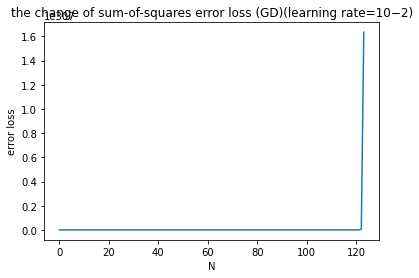

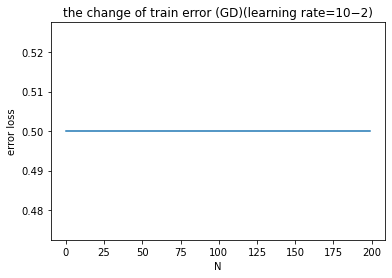

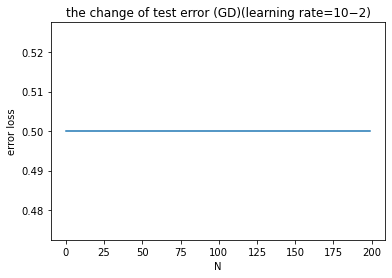

In [20]:


all_labels = np.concatenate((labels[0:10], labels[290: 300]))
all_data = np.concatenate((data[0:10, ], data[290: 300, :]))
# selecting 3 images per class    
training_ind, testing_ind = partition_data(all_labels, num_per_class = 3)

training_data = all_data[training_ind, :]
# the training data is total length 6 because we are getting 3 images per subject for training - sample_1 and 3
training_label = np.zeros(6)
training_label[0:3] = 1        
training_label[3:6] = 30
# testing_data.shape[0] =  14- every sample has 10 images, after taking 3 from each sample, there 7 each for the testing data.
testing_data = all_data[testing_ind, :]
testing_label = np.zeros(14)
testing_label[0:7] = 1
testing_label[7:14] = 30
 

cost_all, w_all = lls_gd_train(training_data, training_label, 10**(-2), 200)

training_error = np.zeros(200)
testing_error = np.zeros(200)
T = (1+30)/2

for i in range(200):
    predict_training = l2_rls_predict(w_all[i], training_data)
    predict_testing = l2_rls_predict(w_all[i], testing_data)
#     using the threshold value (mean of two subjects) to classify the subject
    training_error[i] = ((predict_training[0:3] >= T).sum() + (predict_training[3:6]<T).sum())/6;
    testing_error[i] = ((predict_testing[0:7] >= T).sum() + (predict_testing[7:14]<T).sum())/14;


plt.title("the change of sum-of-squares error loss (GD)(learning rate=10−2)")
plt.plot(np.arange(200), cost_all)
plt.xlabel("N")
plt.ylabel("error loss")
plt.show()
plt.title("the change of train error (GD)(learning rate=10−2)")
plt.plot(np.arange(200), training_error)
plt.xlabel("N")
plt.ylabel("error loss")
plt.show()
plt.title("the change of test error (GD)(learning rate=10−2)")
plt.plot(np.arange(200), testing_error)
plt.xlabel("N")
plt.ylabel("error loss")
plt.show()



#### Report

How did you choose the learning rate and iteration number, explain your results.

## 5. Compare with stochastic gradient descent training (7 Marks In Total)
### 5.1 SGD Implementation (2 Marks, Normal)
Replace the gradient descent approach that you did in 4 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt the similar implementation template as used in your `lls_gd_train` function.

In [21]:

def lls_sgd_train(data, labels, learning_rate, N):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    one = np.ones((X.shape[0], 1))
    X_tilde = np.append(one, X, axis=1)
    
    # Weight initialization
    w = np.zeros(X_tilde.shape[1])
    
    cost_all = []
    w_all = []
    
    # GD update of weights
    for i in range(N):
#         #Choosing a x randomly
        ind = np.random.choice(X_tilde.shape[0], 1, replace=False)
        random_x = X_tilde[ind, :]
        random_y = y[ind]
        
        gd = (random_x.T @ random_x) @ w - random_x.T @ random_y
        cost = np.square(random_x @ w - random_y)/ 2
        
        # Weight update
        w = w - learning_rate * gd
        # save w and cost of each iteration in w_all and cost_all 
        w_all.append(w)
        cost_all.append(cost)
    
    # Return model parameters.
    return cost_all, w_all


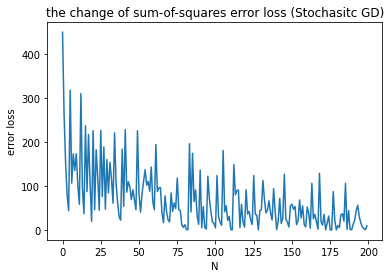

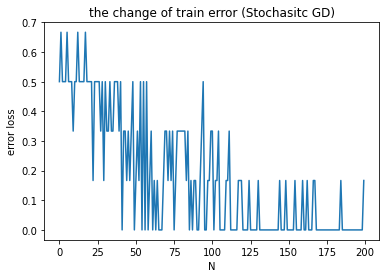

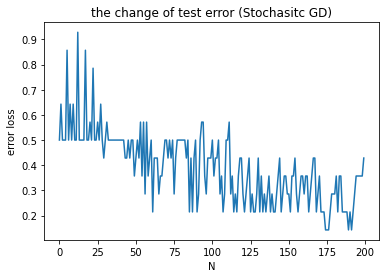

In [22]:

all_labels = np.concatenate((labels[0:10], labels[290: 300]))
all_data = np.concatenate((data[0:10, ], data[290: 300, :]))
# selecting 3 images per class    
training_ind, testing_ind = partition_data(all_labels, num_per_class = 3)

training_data = all_data[training_ind, :]
# the training data is total length 6 because we are getting 3 images per subject for training - sample_1 and 3
training_label = np.zeros(6)
training_label[0:3] = 1        
training_label[3:6] = 30
# testing_data.shape[0] =  14- every sample has 10 images, after taking 3 from each sample, there 7 each for the testing data.
testing_data = all_data[testing_ind, :]
testing_label = np.zeros(14)
testing_label[0:7] = 1
testing_label[7:14] = 30
 
sgd_cost_all, sgd_w_all = lls_sgd_train(training_data, training_label, 10**(-3), 200)

sgd_training_error = np.zeros(200)
sgd_testing_error = np.zeros(200)
T = (1+30)/2

for i in range(200):
    sgd_predict_training = l2_rls_predict(sgd_w_all[i], training_data)
    sgd_predict_testing = l2_rls_predict(sgd_w_all[i], testing_data)
#     using the threshold value (mean of two subjects) to classify the subject
    sgd_training_error[i] = ((sgd_predict_training[0:3] >= T).sum() + (sgd_predict_training[3:6]<T).sum())/6;
    sgd_testing_error[i] = ((sgd_predict_testing[0:7] >= T).sum() + (sgd_predict_testing[7:14]<T).sum())/14;


plt.title("the change of sum-of-squares error loss (Stochasitc GD)")
plt.plot(np.arange(200), sgd_cost_all)
plt.xlabel("N")
plt.ylabel("error loss")
plt.show()
plt.title("the change of train error (Stochasitc GD)")
plt.plot(np.arange(200), sgd_training_error)
plt.xlabel("N")
plt.ylabel("error loss")
plt.show()
plt.title("the change of test error (Stochasitc GD)")
plt.plot(np.arange(200), sgd_testing_error)
plt.xlabel("N")
plt.ylabel("error loss")
plt.show()




### 5.2 Experiment Design (5 Marks, Hard)
Design and implement an appropriate experiment to demonstrate the perforamnce and behaviour difference between gradient descent and stochastic gradient descent. 


In [23]:
import time

# Testing the operation time
all_labels = np.concatenate((labels[0:10], labels[290: 300]))
all_data = np.concatenate((data[0:10, ], data[290: 300, :]))
# selecting 3 images per class    
training_ind, testing_ind = partition_data(all_labels, num_per_class = 3)

training_data = all_data[training_ind, :]
# the training data is total length 6 because we are getting 3 images per subject for training - sample_1 and 3
training_label = np.zeros(6)
training_label[0:3] = 1        
training_label[3:6] = 30
# testing_data.shape[0] =  14- every sample has 10 images, after taking 3 from each sample, there 7 each for the testing data.
testing_data = all_data[testing_ind, :]
testing_label = np.zeros(14)
testing_label[0:7] = 1
testing_label[7:14] = 30

print("The execution time for two methods with different amount of iteration. ")

for i in range(3):
    N = 10**(i+1)
    print("\nThe iteration size (N) is: ", N)
    print("\nGradient Descent: ")
    gd_time = %timeit -o -n 10 lls_gd_train(training_data, training_label, 10**(-3), N)
    print("\nStochastic Gradient Descent: ")
    sgd_time = %timeit -o -n 10 lls_sgd_train(training_data, training_label, 10**(-3), N)
    faster = 100* (((sum(gd_time.timings) - sum(sgd_time.timings)) / sum(gd_time.timings))/len(gd_time.timings))
#     print("\nThe execution time for Stochastic Gradient Descent is ", round(faster, 2), "% faster than the Gradient Decent.")
    time.sleep(3)
    print("------------------------------------------------------------------------------------------------------------------")



The execution time for two methods with different amount of iteration. 

The iteration size (N) is:  10

Gradient Descent: 
12 ms ± 730 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Stochastic Gradient Descent: 
15.7 ms ± 352 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
------------------------------------------------------------------------------------------------------------------

The iteration size (N) is:  100

Gradient Descent: 
127 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Stochastic Gradient Descent: 
158 ms ± 4.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
------------------------------------------------------------------------------------------------------------------

The iteration size (N) is:  1000

Gradient Descent: 
1.36 s ± 39.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Stochastic Gradient Descent: 
1.62 s ± 19.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
------------------------------

Showing the behaviour and the error rates for both GD and SGD with different iteration size


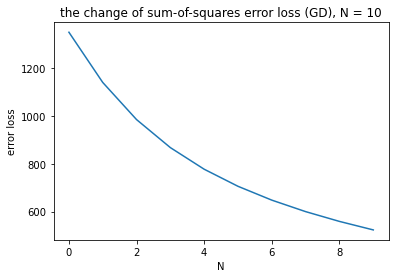

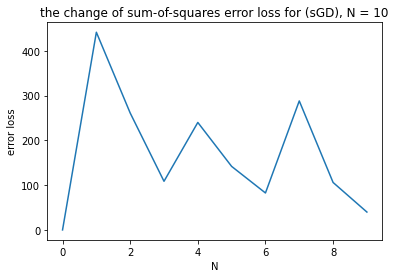

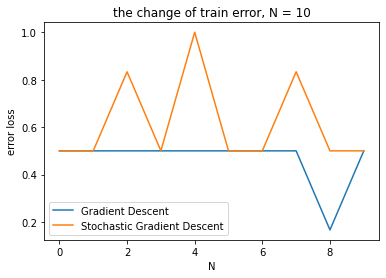

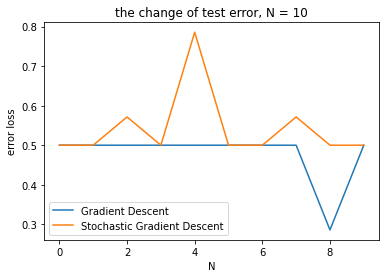

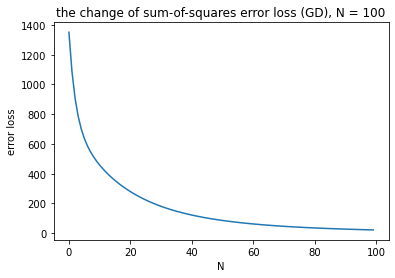

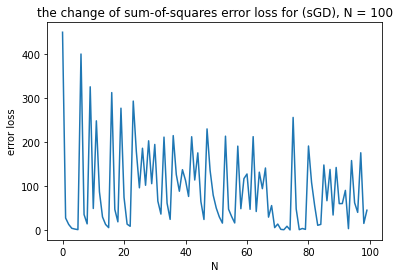

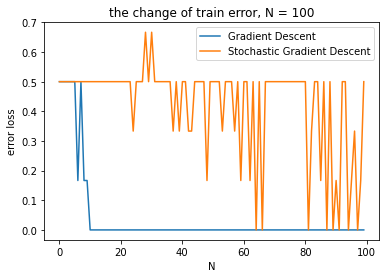

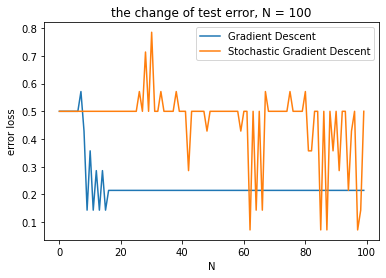

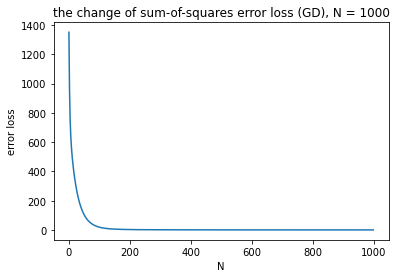

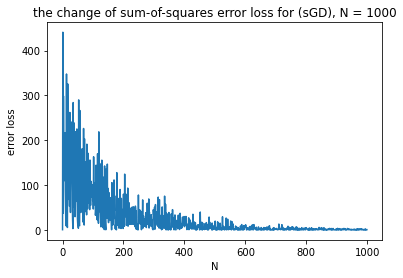

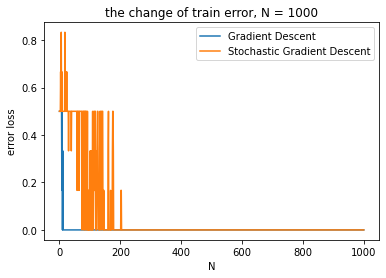

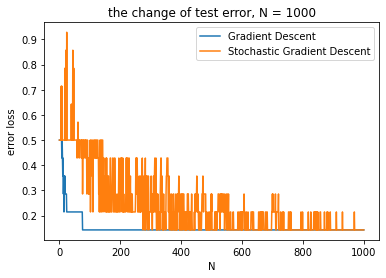

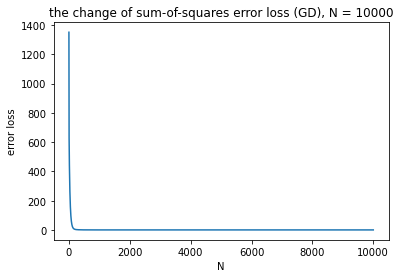

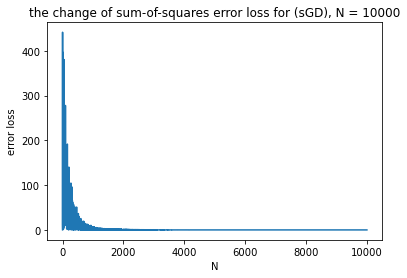

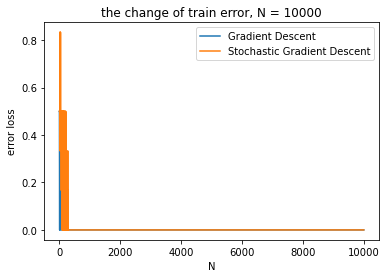

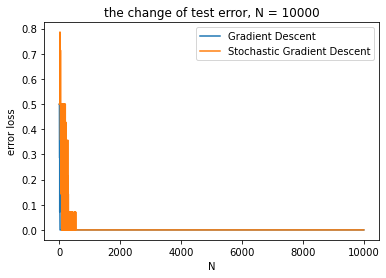

In [24]:
# testing the behaviour of both methods
print("Showing the behaviour and the error rates for both GD and SGD with different iteration size")
for i in range(4):
    
    all_labels = np.concatenate((labels[0:10], labels[290: 300]))
    all_data = np.concatenate((data[0:10, ], data[290: 300, :]))
    # selecting 3 images per class    
    training_ind, testing_ind = partition_data(all_labels, num_per_class = 3)

    training_data = all_data[training_ind, :]
    # the training data is total length 6 because we are getting 3 images per subject for training - sample_1 and 3
    training_label = np.zeros(6)
    training_label[0:3] = 1        
    training_label[3:6] = 30
    # testing_data.shape[0] =  14- every sample has 10 images, after taking 3 from each sample, there 7 each for the testing data.
    testing_data = all_data[testing_ind, :]
    testing_label = np.zeros(14)
    testing_label[0:7] = 1
    testing_label[7:14] = 30


    N = 10**(i+1)
    cost_all_gd, w_all_gd = lls_gd_train(training_data, training_label, 10**(-3), N)
    cost_all_sgd, w_all_sgd =  lls_sgd_train(training_data, training_label, 10**(-3), N)

    
    gd_training_error = np.zeros(N)
    gd_testing_error = np.zeros(N)
    sgd_training_error = np.zeros(N)
    sgd_testing_error = np.zeros(N)
    T = (1+30)/2

    for i in range(N):
        gd_predict_training = l2_rls_predict(w_all_gd[i], training_data)
        gd_predict_testing = l2_rls_predict(w_all_gd[i], testing_data)
        gd_training_error[i] = ((gd_predict_training[0:3] >= T).sum() + (gd_predict_training[3:6]<T).sum())/6;
        gd_testing_error[i] = ((gd_predict_testing[0:7] >= T).sum() + (gd_predict_testing[7:14]<T).sum())/14;

        sgd_predict_training = l2_rls_predict(w_all_sgd[i], training_data)
        sgd_predict_testing = l2_rls_predict(w_all_sgd[i], testing_data)
        sgd_training_error[i] = ((sgd_predict_training[0:3] >= T).sum() + (sgd_predict_training[3:6]<T).sum())/6;
        sgd_testing_error[i] = ((sgd_predict_testing[0:7] >= T).sum() + (sgd_predict_testing[7:14]<T).sum())/14;

    plt.title("the change of sum-of-squares error loss (GD), N = " + str(N))
    plt.plot(np.arange(N), cost_all_gd, label='Gradient Descent')
    plt.xlabel("N")
    plt.ylabel("error loss")
    plt.show()

    plt.title("the change of sum-of-squares error loss for (sGD), N = " + str(N))
    plt.plot(np.arange(N), cost_all_sgd, label='Stochastic Gradient Descent')
    plt.xlabel("N")
    plt.ylabel("error loss")
    plt.show()

    plt.title("the change of train error, N = " + str(N))
    plt.plot(np.arange(N), gd_training_error, label='Gradient Descent')
    plt.plot(np.arange(N), sgd_training_error, label='Stochastic Gradient Descent')
    plt.xlabel("N")
    plt.ylabel('error loss')
    plt.legend()
    plt.show()

    plt.title("the change of test error, N = " + str(N))
    plt.plot(np.arange(N), gd_testing_error, label='Gradient Descent')
    plt.plot(np.arange(N), sgd_testing_error, label='Stochastic Gradient Descent')
    plt.xlabel("N")
    plt.ylabel("error loss")
    plt.legend()
    plt.show()

test with different learning rate


<ipython-input-18-4634c3a86692>:29: RuntimeWarning: overflow encountered in square
  cost = np.sum(np.square(predicted_y - y))/ 2
<ipython-input-18-4634c3a86692>:28: RuntimeWarning: overflow encountered in matmul
  gd = X_tilde.T @X_tilde @w - X_tilde.T @ y
<ipython-input-18-4634c3a86692>:27: RuntimeWarning: overflow encountered in matmul
  predicted_y = X_tilde @ w
<ipython-input-18-4634c3a86692>:32: RuntimeWarning: invalid value encountered in subtract
  w = w - learning_rate * gd
<ipython-input-21-2102b673de57>:31: RuntimeWarning: overflow encountered in square
  cost = np.square(random_x @ w - random_y)/ 2
<ipython-input-7-3045e756ebda>:18: RuntimeWarning: overflow encountered in matmul
  predicted_y = X_tilde @ w


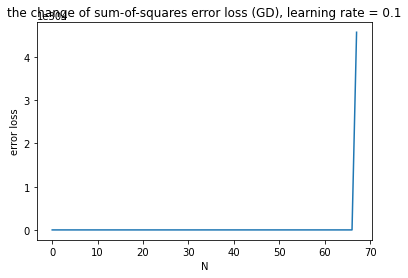

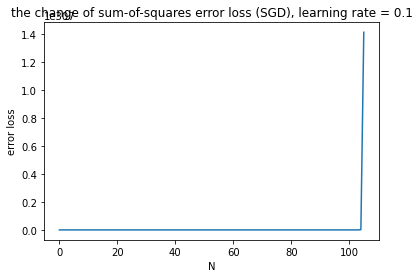

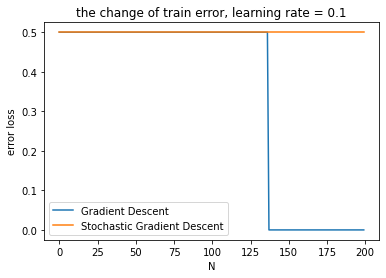

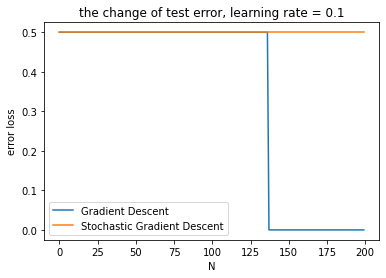

<ipython-input-18-4634c3a86692>:29: RuntimeWarning: overflow encountered in square
  cost = np.sum(np.square(predicted_y - y))/ 2


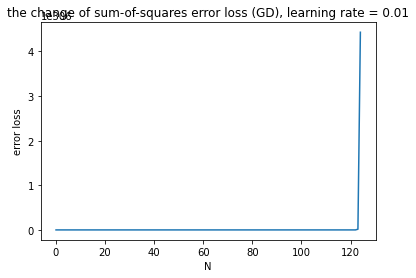

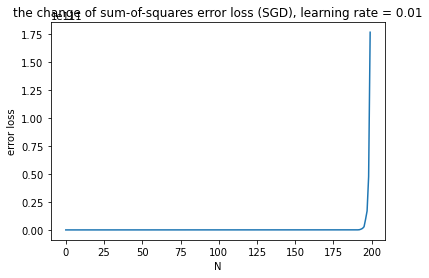

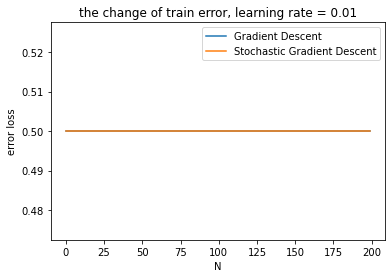

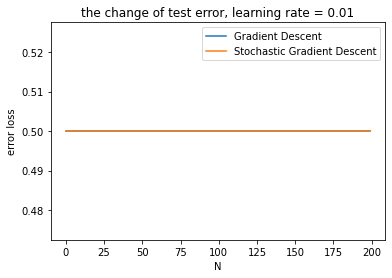

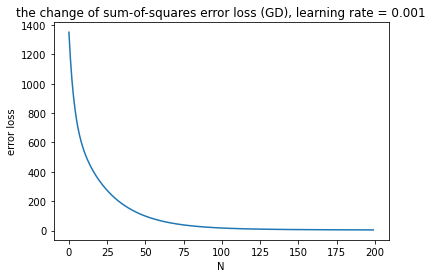

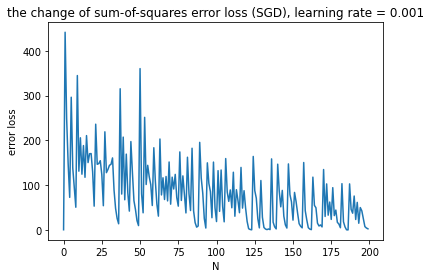

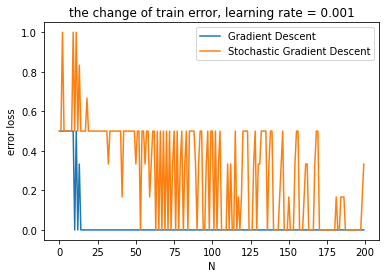

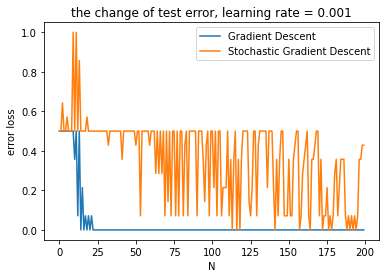

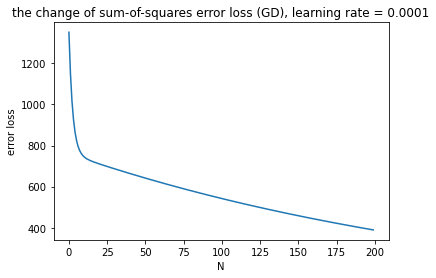

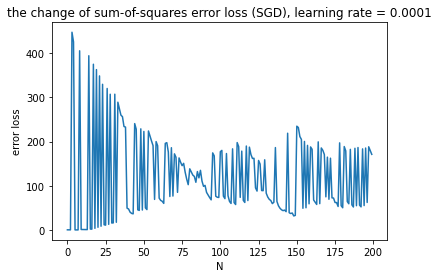

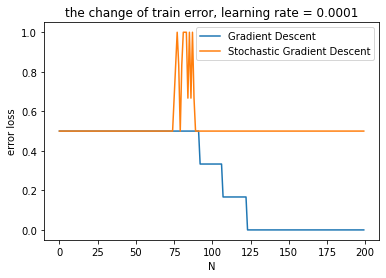

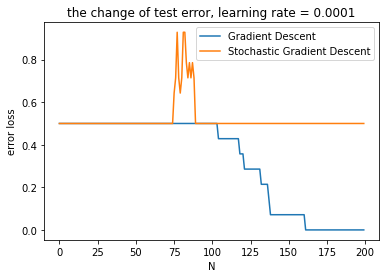

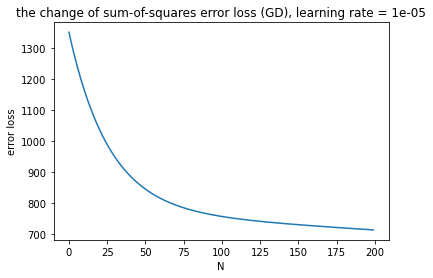

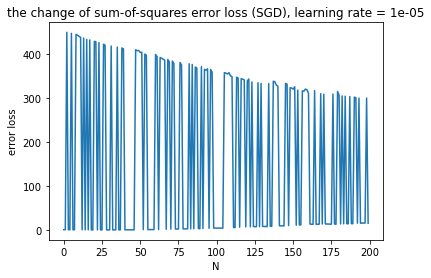

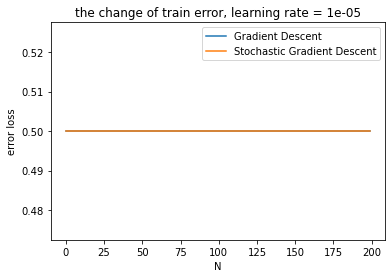

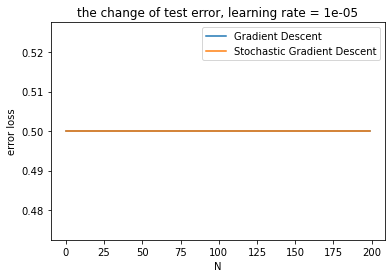

In [25]:
# to test with different learning rate
print("test with different learning rate")
for i in range(5):
    
    all_labels = np.concatenate((labels[0:10], labels[290: 300]))
    all_data = np.concatenate((data[0:10, ], data[290: 300, :]))
    # selecting 3 images per class    
    training_ind, testing_ind = partition_data(all_labels, num_per_class = 3)

    training_data = all_data[training_ind, :]
    # the training data is total length 6 because we are getting 3 images per subject for training - sample_1 and 3
    training_label = np.zeros(6)
    training_label[0:3] = 1        
    training_label[3:6] = 30
    # testing_data.shape[0] =  14- every sample has 10 images, after taking 3 from each sample, there 7 each for the testing data.
    testing_data = all_data[testing_ind, :]
    testing_label = np.zeros(14)
    testing_label[0:7] = 1
    testing_label[7:14] = 30


    learning_rate = 10**(-(i+1))
    cost_all_gd, w_all_gd = lls_gd_train(training_data, training_label, learning_rate, 200)
    cost_all_sgd, w_all_sgd =  lls_sgd_train(training_data, training_label, learning_rate, 200)

    
    gd_training_error = np.zeros(200)
    gd_testing_error = np.zeros(200)
    sgd_training_error = np.zeros(200)
    sgd_testing_error = np.zeros(200)
    T = (1+30)/2

    for i in range(200):
        gd_predict_training = l2_rls_predict(w_all_gd[i], training_data)
        gd_predict_testing = l2_rls_predict(w_all_gd[i], testing_data)
        gd_training_error[i] = ((gd_predict_training[0:3] >= T).sum() + (gd_predict_training[3:6]<T).sum())/6;
        gd_testing_error[i] = ((gd_predict_testing[0:7] >= T).sum() + (gd_predict_testing[7:14]<T).sum())/14;

        sgd_predict_training = l2_rls_predict(w_all_sgd[i], training_data)
        sgd_predict_testing = l2_rls_predict(w_all_sgd[i], testing_data)
        sgd_training_error[i] = ((sgd_predict_training[0:3] >= T).sum() + (sgd_predict_training[3:6]<T).sum())/6;
        sgd_testing_error[i] = ((sgd_predict_testing[0:7] >= T).sum() + (sgd_predict_testing[7:14]<T).sum())/14;

    plt.title( "the change of sum-of-squares error loss (GD), learning rate = " + str(learning_rate))
    plt.plot(np.arange(200), cost_all_gd, label='Gradient Descent')
    plt.xlabel("N")
    plt.ylabel("error loss")
    plt.show()

    plt.title( "the change of sum-of-squares error loss (SGD), learning rate = " + str(learning_rate))
    plt.plot(np.arange(200), cost_all_sgd, label='Stochastic Gradient Descent')
    plt.xlabel("N")
    plt.ylabel("error loss")
    plt.show()

    plt.title("the change of train error, learning rate = "+ str(learning_rate))
    plt.plot(np.arange(200), gd_training_error, label='Gradient Descent')
    plt.plot(np.arange(200), sgd_training_error, label='Stochastic Gradient Descent')
    plt.xlabel("N")
    plt.ylabel('error loss')
    plt.legend()
    plt.show()

    plt.title("the change of test error, learning rate = "+ str(learning_rate))
    plt.plot(np.arange(200), gd_testing_error, label='Gradient Descent')
    plt.plot(np.arange(200), sgd_testing_error, label='Stochastic Gradient Descent')
    plt.xlabel("N")
    plt.ylabel("error loss")
    plt.legend()
    plt.show()

#### Report  

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

#### Remember that all graphs should have axis labels and a title.